# METEOCPY Intro

## Imports

In [1]:
PATH = '/Users/jim' # replace with the parent director of your meteocpy installation
DATA_PATH = '/Users/jim/meteoc' # replace with the parent directory of where you installed data and params

In [2]:
import sys
sys.path.append(PATH)

In [3]:
import meteocpy as mpy
from meteocpy.forward import apex
from meteocpy import utils
from meteocpy.utils import load_params, BiDict

import numpy as np
import os
import matplotlib.pyplot as plt
from os.path import join as pjoin

from importlib import reload

In [4]:
%matplotlib inline

In [5]:
# if you change the code and want to run it here with your changes, run this cell first!
reload(apex)
reload(utils)

<module 'meteocpy.utils' from '/Users/jim/meteocpy/utils.py'>

## Simulation preparation

In [6]:
# Instantiate a sensor from the SRF parameterization and meta variables (see directory for an example)
ap = apex.load_apex(unbinned_vnir=pjoin(DATA_PATH, 'params/unbinned'),
                    binned_vnir_swir=pjoin(DATA_PATH,'params/binned'),
                    binned_meta=pjoin(DATA_PATH,'params/binned_meta'), 
                    vnir_it=27000, swir_it=15000)

/Users/jim/meteocpy/forward/apex.py:123: UserWarning: WARNING: you loaded unbinned calibration files but meta files are binned. Make sure tocall initialize_srfs with kwarg do_bin=True.
  warnings.warn('WARNING: you loaded unbinned calibration files but meta files are binned. Make sure to'


### abs_res: absolute resolution (at arbitrary positions)

This is just for visualization purposes. Don't use this initializition mode, use exact_wvls (shown below). 

In [31]:
# initialize an apex sensor with 0.1 nm resolution, the SRFs are initialized with a support of at least 3 sigma 
# use zero_out=True to cut off all SRFs at exactly 3 sigma, use do_bin to bin the VNIR SRFs (this is necessary 
# because binned meta variables were supplied).

ap.initialize_srfs(inp_support=[600, 700], 
                   abs_res=0.1,
                   srf_support_in_sigma=3, 
                   zero_out=True, 
                   do_bin=True)

In [32]:
# Note that you got your model in the dictionary in ap.model.binned
dict(zip(ap.model.binned.keys(), [type(v) for k, v in ap.model.binned.items()]))

{'srfs': numpy.ndarray,
 'wvls': numpy.ndarray,
 'initialized_support': list,
 'srf_support_per_band': numpy.ndarray,
 'srf_bands': numpy.ndarray,
 'res': NoneType,
 'abs_res': float,
 'start_band': numpy.int64,
 'calc_mode': str}

In [36]:
# meteocpy figures out which bands are relevant for you given inp_support and 
# the requested SRF width (srf_support_in_sigma). 
ap.model.binned['srf_bands']

array([30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46,
       47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63])

In [37]:
# and the corresponding supports are in 
ap.model.binned['srf_support_per_band']

array([[593.65556354, 603.35089681],
       [597.9957556 , 607.95720938],
       [602.58791728, 612.83484892],
       [607.21482484, 617.60770768],
       [611.82823922, 622.47106819],
       [616.57699996, 624.99419064],
       [619.02658075, 627.55950519],
       [621.53630217, 630.17021383],
       [624.09252399, 632.83762899],
       [626.68574813, 635.54355593],
       [629.29627314, 638.26105773],
       [631.89859129, 640.97909153],
       [634.50263803, 643.70739206],
       [637.12800558, 646.46010239],
       [639.79428591, 649.25136589],
       [642.52107071, 652.0953262 ],
       [645.31870383, 655.00283336],
       [648.16743123, 657.97324223],
       [651.06511648, 661.00465907],
       [654.00712181, 664.07685088],
       [656.96423764, 667.16087576],
       [659.91778775, 670.24120083],
       [662.88170703, 673.34389875],
       [665.88242601, 676.50176302],
       [668.95235491, 679.72231808],
       [672.10589844, 683.0253225 ],
       [675.33057862, 686.39983343],
 

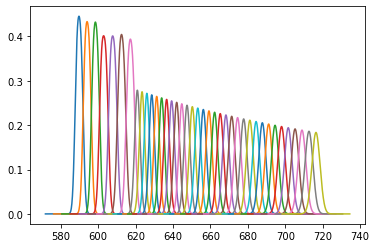

In [18]:
# plot srfs at xtrack 500 
n = 500
_ = plt.plot(np.array(ap.model.binned.wvls[:, n]).transpose(), 
             np.array(ap.model.binned.srfs[0, :, n]).transpose())

# *TODO* here it is important to discuss normalization of those SRFs

### exact_wvls: exact wavelengths

Since you know the wavelengths of the input spectrum in advance, calculate the SRFs at exactly these positions. 
Initialization has to be done only once if the wvls do not change.

In [7]:
# do_bin=True because binned meta variables but unbinned SRF parameters were suplied
init_wvls = np.arange(600, 700, 0.01)
ap.initialize_srfs(exact_wvls=init_wvls, 
                   do_bin=True)

In [8]:
# Note that you got your model in the dictionary in ap.model.binned
dict(zip(ap.model.binned.keys(), [type(v) for k, v in ap.model.binned.items()]))

{'srfs': list,
 'wvls': list,
 'initialized_support': tuple,
 'srf_support_per_band': numpy.ndarray,
 'srf_bands': numpy.ndarray,
 'res': NoneType,
 'abs_res': NoneType,
 'start_band': numpy.int64,
 'calc_mode': str}

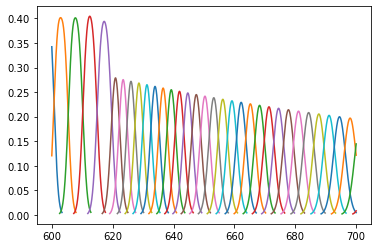

In [9]:
# plot the calculated SRF positions for xtrack 500
n = 500
for i in range(len(ap.model.binned.wvls)):
    _ = plt.plot(np.array(ap.model.binned.wvls[i]).transpose(), 
                 np.array(ap.model.binned.srfs[i][0, n, :]).transpose())
plt.show()

## Simulation

The **input spectrum** has to be defined on a set of wvls that form a subset to the initializing wvls (that's the idea behind exact_wvls). I will call this subset **input support**.

Your input needs to have specific dimensions. This decides how the simulation is computed. You can have up to 5 dims for the input. Depending on how many you supply, meteocpy will assume different roles for the dimensions. Basically, the inp_spectrum batch dimension aligns with the inp_wvls first (batch) dimension. The channel dimension bundles different input simulations on the same input support. Internally, the input you supply is expanded internally to an input image, i.e. your input has effectively x and y dimension corresponding to the sensor frame's xtrack and spectral band dimension. When expansion is necessary (bc you didn't supply all dimensions), a homogeneous illumination on the whole sensor is assumed.

Allowed combinations are  
* **1d** (wvl): assumes single batch dim, hom. illumination
* **2d** (batch, wvl): assumes single channel dim, hom. illumination
* **3d** (batch, channel, wvl): assumes hom. illumination
* **4d** (batch, channel, pix, wvl): Not implemented, pix would be the flattened (band, xtrack)
* **5d** (batch, channel, band, xtrack, wvl): everything is well-defined :)

**Note** that the batch dimension can be ragged, i.e. you can supply the first dim as a list. This is necessary if you want to simulate in parallel inp_spectra of different support sizes (array dimensions are different).

**Note** that the parallelization goes over batches, not channels. This can be changed easily in the code, has been found to slow the computation down, however.

**Note** inp_wvlens can be 1d, then it is assumed to be the same for all batches, or else it must be specified for each batch.

**Note** the simulation returns a list with apex frames for each batch. Eac

In [22]:
# configure simulation
simu_config = dict(pad=False, # whether to return the whole frame or 
                              # only illuminated spectral bands? (note no dc in in non illuminated bands)
                   
                   part_covered=True, # criterion for a band to be illuminated: overlapping supports is enough
                   
                   invert=True, # simulation steps
                   snr=True, 
                   dc=True, 
                   smear=True, 
                   
                   return_binned=False, # binning after forward simulaton is currently not implemented
                                        # this should actually be done for physical correctness
                   
                   run_specs=dict(joblib=True, # joblib activates parallel executuion
                                  n_jobs=4, # how many cores
                                  batches_per_job=3 , # how many batches per core
                                  ),
                   
                   conv_mode='numba' # whether to use the numba library for convolution (best leave that)
                  )

In [35]:
# create a single spectrum homogeneously over the whole frame 
inp_spectrum = np.array([1e6, 1e6,1e6, 1e5, 1e6, 1e6, 1e4])#.reshape(1, 1, -1)
inp_wvls = np.arange(600, 607, 1)#.reshape(1, -1)

res, illu_bands = ap.forward(inp_spectrum=inp_spectrum, inp_wvlens=inp_wvls, **simu_config)

In [36]:
# result shape (channel, band, xtrack)
len(res), res[0].shape

(1, (1, 3, 1000))

In [31]:
# Changing input dimensions, changes the simulation to mono.
# Now each batch has a dirac spectrum (single wavelength, no physical width)
inp_spectrum = np.array([1e6, 1e6,1e6, 1e5, 1e6, 1e6, 1e4]).reshape(-1, 1, 1)
inp_wvls = np.arange(600, 607, 1).reshape(-1, 1)

res, illu_bands = ap.forward(inp_spectrum=inp_spectrum, inp_wvlens=inp_wvls, **simu_config)

In [33]:
# result shape (channel, band, xtrack)
len(res), res[0].shape

(7, (1, 2, 1000))

In [37]:
# Try a simulation with channels shape (1, 2, 7)
inp_spectrum = np.array([[[1e6, 1e6,1e6, 1e5, 1e6, 1e6, 1e4], 
                          [.5e6, .5e6, .5e6, .2e5, .1e6, .1e6, .1e4]]])
inp_wvls = np.arange(600, 607, 1)

res, illu_bands = ap.forward(inp_spectrum=inp_spectrum, inp_wvlens=inp_wvls, **simu_config)

In [38]:
# result shape (channel, band, xtrack)
len(res), res[0].shape

(1, (2, 3, 1000))

In [30]:
# For an example with many batches, see calibration/run_experiment.py